# How Bias Enters a Model

This notebook is a simple demonstration of how bias with respect an attribute can get encoded into a model, even if the labels are perfectly accurate and the model is unaware of the attribute.

In [1]:
%matplotlib inline
from IPython.display import display, Markdown, Latex
import numpy as np
import sklearn
import matplotlib
import matplotlib.pylab as plt
import sklearn.linear_model
import seaborn
import scipy.special
seaborn.set(rc={"figure.figsize": (8, 6)}, font_scale=1.5)

## Generate Data

Let's generate some data with a simple model. There's a binary sensitive `attribute` $A$, `predictor1` $p_1$ uncorrelated with the attribute, `predictor2` $p_2$ correlated with the attribute, random `noise` $\epsilon$, and a binary label $y$ that's correlated with both predictors.

$$P(y=1) = \mathrm{Logistic}(p_1 + p_2 + \epsilon)$$

where

$$p1 \sim \mathrm{Normal}(0,1)$$

$$p2 \sim \mathrm{Normal}(0,1) \iff A=a$$

$$p2 \sim \mathrm{Normal}(1,1) \iff A=b$$

$$\epsilon \sim \mathrm{Normal}(0,1)$$

In [2]:
n = 10000 # Sample size.

# Create an attribute.
attribute = np.choose(np.random.rand(n) > 0.5, ['a', 'b'])

# Create an uncorrelated predictor.
predictor1 = np.random.randn(n) 

# Create a predictor correlated with the attribute.
disparity_scale = 1.0
predictor2 = np.random.randn(n) + ((attribute == 'b') * disparity_scale)

# Generate random noise.
noise_scale = 1.0
noise = np.random.randn(n) * noise_scale

# Calculate the probability of the binary label.
scale = 1.0
p_outcome = scipy.special.expit(scale * (predictor1 + predictor2 + noise))

# Calculate the outcome.
y = p_outcome > np.random.rand(n)

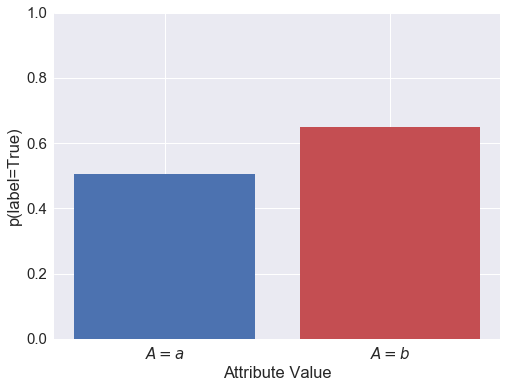

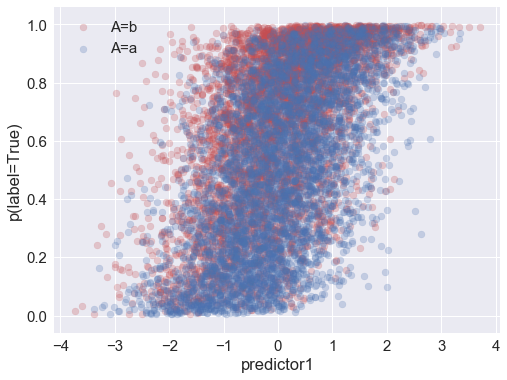

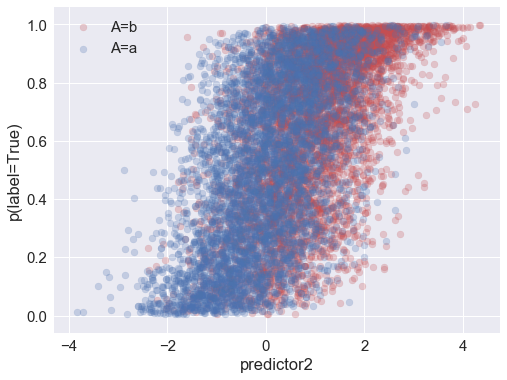

In [3]:
seaborn.set(rc={"figure.figsize": (8, 6)}, font_scale=1.5)
c0 = seaborn.color_palette()[0]
c1 = seaborn.color_palette()[2]

plt.figure(figsize=(8,6))
plt.bar([0], [y[attribute == 'a'].mean()], fc=c0)
plt.bar([1], [y[attribute == 'b'].mean()], fc=c1)
plt.xticks([0.0,1.0], ['$A=a$', '$A=b$'])
plt.xlabel("Attribute Value")
plt.ylabel("p(label=True)")
plt.ylim(0,1);

plt.figure()
plt.scatter(predictor1[attribute == 'b'], p_outcome[attribute == 'b'], c=c1, alpha=0.25, label='A=b')
plt.scatter(predictor1[attribute == 'a'], p_outcome[attribute == 'a'], c=c0, alpha=0.25, label='A=a')
plt.xlabel('predictor1')
plt.ylabel('p(label=True)')
plt.legend(loc='best')

plt.figure()
plt.scatter(predictor2[attribute == 'b'], p_outcome[attribute == 'b'], c=c1, alpha=0.25, label='A=b')
plt.scatter(predictor2[attribute == 'a'], p_outcome[attribute == 'a'], c=c0, alpha=0.25, label='A=a')
plt.xlabel('predictor2')
plt.ylabel('p(label=True)')
plt.legend(loc='best');

Above you can see that the probability of (actually) being in the positive class is correlated with the attribute and with one of the predictors. This results in points with attribute $A=b$ being much more likely to be in the positive class.

In [4]:
display(Markdown("Condition Positive Fraction for each attribute class: (a,b): {:.3f} {:.3f}".format(
    y[attribute == 'a'].mean(), y[attribute == 'b'].mean())))
display(Markdown(
    "Members of the $A=b$ group are {:.0f}% more likely to have the positive label than $b$ group.".format(
    100.0 * (y[attribute == 'b'].mean()/y[attribute == 'a'].mean() - 1.0))))

Condition Positive Fraction for each attribute class: (a,b): 0.506 0.650

Members of the $A=b$ group are 28% more likely to have the positive label than $b$ group.

## Fit a Model

We have our dataset now, with two predictors and a binary outcome. Let's fit a logistic regression model to it.

In [5]:
# Put the predictors into the expected sklearn format.
X = np.vstack([predictor1, predictor2]).T
# Initialize our logistic regression classifier.
clf = sklearn.linear_model.LogisticRegression()
# Perform the fit.
clf.fit(X, y)
# Model fit parameters:
clf.intercept_, clf.coef_

(array([-0.00794129]), array([[ 0.81930492,  0.84255871]]))

Now generate predictions from the model.

In [6]:
p = clf.predict_proba(X)[:,1]
yhat = p > 0.5

## Amplification of bias

There was an initial disparity between the attribute classes in terms of their _actual_ labels: the $A=b$ group was much more likely to get the positive label than the $A=a$ group. Now let's see how that disparity is reflected in the _predicted_ labels.

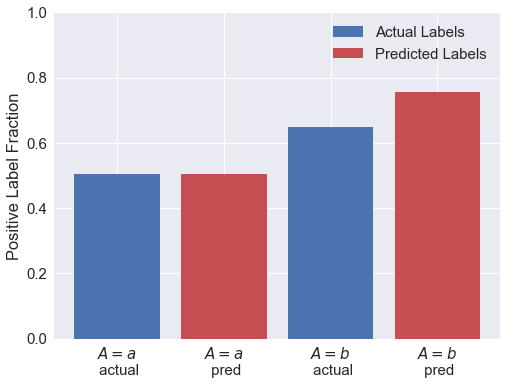

In [7]:
plt.figure(figsize=(8,6))

plt.bar([0, 2], [y[attribute == 'a'].mean(), y[attribute == 'b'].mean()],
        fc=c0, label='Actual Labels')
plt.bar([1, 3], [yhat[attribute == 'a'].mean(), yhat[attribute == 'b'].mean()],
        fc=c1, label='Predicted Labels')

plt.xticks([0.0, 1.0, 2.0, 3.0], ['$A=a$ \n actual', '$A=a$ \n pred', '$A=b$ \n actual', '$A=b$ \n pred'])
plt.ylabel("Positive Label Fraction")
plt.ylim(0,1)
plt.legend(loc='best');

In [8]:
display(Markdown("Condition Positive fraction for each attribute class: (a,b): {:.0f}% {:.0f}%".format(
    100.0 * y[attribute == 'a'].mean(), 100.0 * y[attribute == 'b'].mean())))
display(Markdown("Predicted Positive fraction for each attribute class: (a,b): {:.0f}% {:.0f}%".format(
    100.0 * yhat[attribute == 'a'].mean(), 100.0 * yhat[attribute == 'b'].mean())))
display(Markdown("""
So the initial {:.0f}% disparity in the _actual_ labels is amplified by the model.
**Members of the $A=b$ group are {:.0f}% more likely to have the positive _predicted_ label than $b$ group.**
The model has amplified the initial disparity by a factor of {:.2f}. 
""".format(
    100.0 * (y[attribute == 'b'].mean()/y[attribute == 'a'].mean() - 1.0),
    100.0 * (yhat[attribute == 'b'].mean()/yhat[attribute == 'a'].mean() - 1.0),
    (yhat[attribute == 'b'].mean()/yhat[attribute == 'a'].mean()) / 
        (y[attribute == 'b'].mean()/y[attribute == 'a'].mean())
                )))

Condition Positive fraction for each attribute class: (a,b): 51% 65%

Predicted Positive fraction for each attribute class: (a,b): 51% 76%


So the initial 28% disparity in the _actual_ labels is amplified by the model.
**Members of the $A=b$ group are 49% more likely to have the positive _predicted_ label than $b$ group.**
The model has amplified the initial disparity by a factor of 1.16. 


## Model Performance

### ROC Curve
Let's plot ROC curves for the whole dataset and for each attribute group to compare model performance:

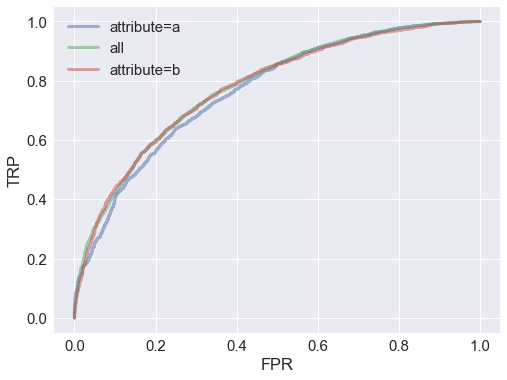

In [9]:
fpr_all, tpr_all, t_all = sklearn.metrics.roc_curve(y, p)
fpr_falseclass, tpr_falseclass, t_falseclass = sklearn.metrics.roc_curve(y[attribute == 'a'], p[attribute == 'a'])
fpr_trueclass, tpr_trueclass, t_trueclass = sklearn.metrics.roc_curve(y[attribute == 'b'], p[attribute == 'b'])

plt.plot(fpr_falseclass, tpr_falseclass, label='attribute=a', alpha=0.5, lw=3)
plt.plot(fpr_all, tpr_all, label='all', alpha=0.5, lw=3)
plt.plot(fpr_trueclass, tpr_trueclass, label='attribute=b', alpha=0.5, lw=3)
plt.legend(loc='best')
plt.xlabel("FPR")
plt.ylabel("TRP");

From the ROC curves, it looks like the model performs about equally well for all groups.

### True Positive Rate

Let's check the true positive rate $P(\hat{y}=1|y=1)$ vs the score threshold. We find that the true positive rate is *better* at all thresholds for the attribute $A=b$ group:

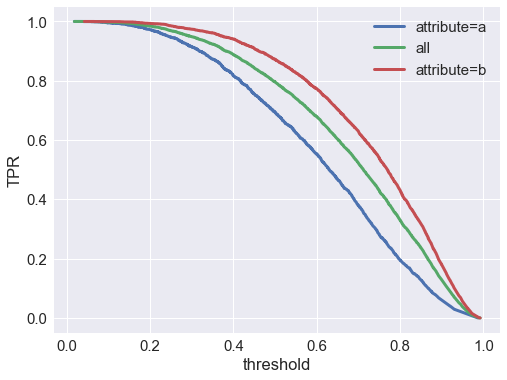

In [10]:
plt.plot(t_falseclass, tpr_falseclass, label='attribute=a', lw=3)
plt.plot(t_all, tpr_all, label='all', lw=3)
plt.plot(t_trueclass, tpr_trueclass, label='attribute=b', lw=3)
plt.legend(loc='best')
plt.xlabel("threshold")
plt.ylabel("TPR");

So it looks like the model will actually perform better in terms of TPR (aka recall) for group $A=b$.

Now let's check the false positive rate $P(\hat{y}=0|y=1)$ vs the score threshold:

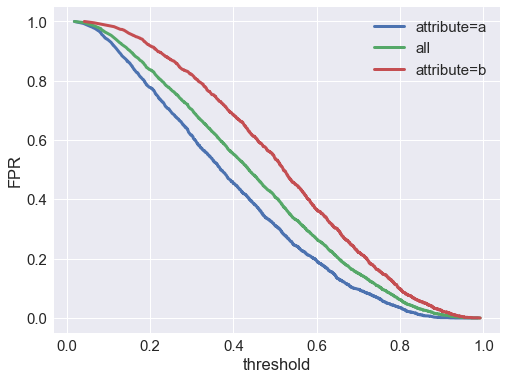

In [11]:
plt.plot(t_falseclass, fpr_falseclass, label='attribute=a', lw=3)
plt.plot(t_all, fpr_all, label='all', lw=3)
plt.plot(t_trueclass, fpr_trueclass, label='attribute=b', lw=3)
plt.legend(loc='best')
plt.xlabel("threshold")
plt.ylabel("FPR");

 We find that the false positive rate is much higher at all thresholds for the $A=b$ group. If the negative class is *preferred* (e.g. in a model predicting fraud, spam, defaulting on a loan, etc.), that means we're *much* more likely to *falsely* classify an *actually-good* member of group $b$ as *bad*, compared to a *actually-good* member of group $a$.

In [12]:
def fpr(y_true, y_pred):
    fp = (np.logical_not(y_true) & y_pred).sum()
    cn = np.logical_not(y_true).sum()
    return 100.0 * fp * 1.0 / cn

display(Markdown("""
At a threshold of model score $= 0.5$, the false positive rate is {:.0f}% overall, **{:.0f}% for group $a$, 
and {:.0f}% for group $b$**.
""".format(
    fpr(y, yhat), fpr(y[attribute=='a'], yhat[attribute=='a']), fpr(y[attribute=='b'], yhat[attribute=='b']))))


At a threshold of model score $= 0.5$, the false positive rate is 41% overall, **31% for group $a$, 
and 54% for group $b$**.


## Conclusion

We've demonstrated that a model trained on *correct* labels, and with no directly access to a particular attribute, can be biased against members a group who deserve the preferred label, merely because that group has a higher incidence of the non-prefered label in the training data. Furthermore, this bias can be hidden, because it's only revealed by comparing false positive rates at a fixed threshold, not other performance metrics.